### Task 3

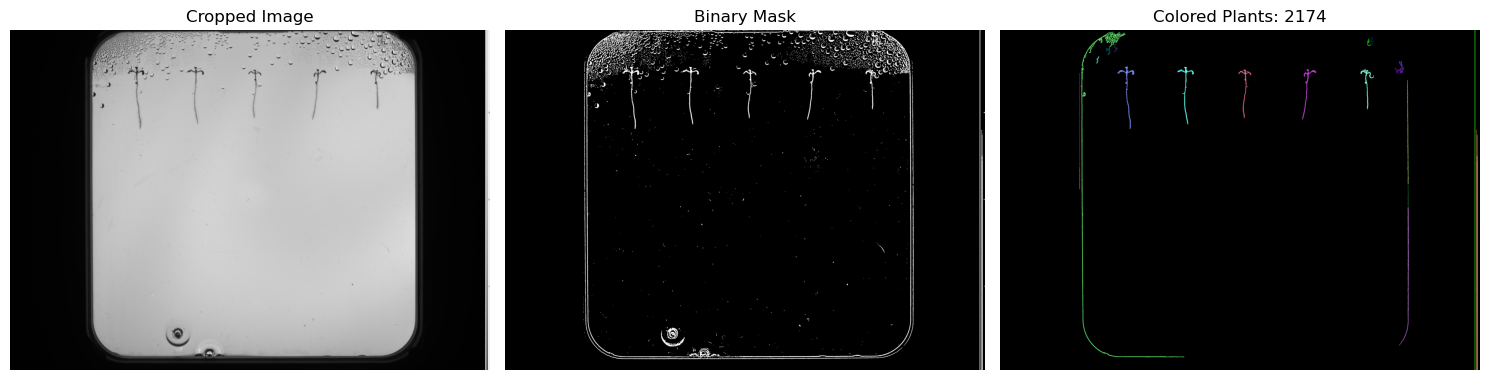

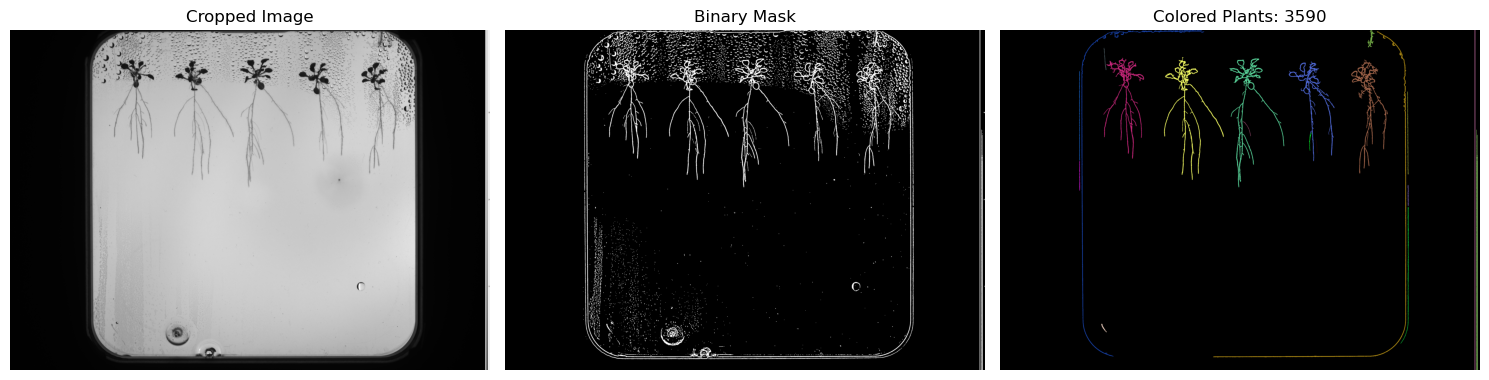

In [3]:
# Import necessary libraries—cv2 for OpenCV functions, numpy for array manipulations, and matplotlib.pyplot for displaying results. 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to the task images
image_paths = ["task_3_image_1.png", "task_3_image_2.png"]

def preprocess_image(image_path, crop_margin=50):
    """
    Preprocess the image: Load, crop the borders, convert to grayscale, and apply median filtering.
    Parameters:
        - crop_margin: Number of pixels to crop from each border.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Crop the borders to remove outline
    h, w = image.shape[:2]
    cropped_image = image[crop_margin:h-crop_margin, crop_margin:w-crop_margin]

    # Convert to grayscale and apply median blur
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)  # Reduce noise
    
    return cropped_image, blurred

def segment_plants(blurred_image):
    """
    Segment the plants using adaptive thresholding, edge detection, and morphological operations.
    """
    # Adaptive thresholding to create a binary mask
    binary = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3
    )

    # Canny Edge Detection for finer root details
    edges = cv2.Canny(blurred_image, 50, 150) #it's not useful

    # Combine binary and edge masks for refined segmentation
    combined = cv2.bitwise_or(binary, edges)

    # Morphological operations to refine binary mask
    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=1)  # Fill gaps
    cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)  # Remove noise

    return cleaned

def filter_and_label_plants(binary_mask):
    """
    Filter small components and label individual plants using connected components with stats.
    """
    # Perform connected components analysis with statistics
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
    # Filter small components based on area and aspect ratio
    min_area = 500  # Minimum area threshold for valid plants
    filtered_mask = np.zeros_like(labels, dtype=np.uint16)  # Use uint16 to avoid overflow

    for label in range(1, num_labels):  # Skip background
        area = stats[label, cv2.CC_STAT_AREA]
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        aspect_ratio = height / width if width > 0 else 0

        # Filter components based on area and aspect ratio
        if area > min_area and aspect_ratio > 1.5:  # Roots typically have higher aspect ratios
            filtered_mask[labels == label] = label

    return filtered_mask

def color_plants(filtered_mask):
    """
    Color each plant with a unique color.
    """
    # Generate random colors for each plant
    num_labels = np.max(filtered_mask)
    colored_image = np.zeros((*filtered_mask.shape, 3), dtype=np.uint8)

    for label in range(1, num_labels + 1):  # Skip background
        mask = (filtered_mask == label)
        color = np.random.randint(0, 255, size=3)  # Random color
        colored_image[mask] = color

    return colored_image, num_labels

def display_results(original, binary, colored, num_plants):
    """
    Display the cropped, binary, and colored plant images.
    """
    plt.figure(figsize=(15, 6))

    # Cropped image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.axis("off")

    # Binary mask
    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap="gray")
    plt.title("Binary Mask")
    plt.axis("off")

    # Colored plants
    plt.subplot(1, 3, 3)
    plt.imshow(colored)
    plt.title(f"Colored Plants: {num_plants}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Process each image
for image_path in image_paths:
    try:
        original, blurred = preprocess_image(image_path, crop_margin=50)  # Crop 50 pixels from each side
        binary_mask = segment_plants(blurred)
        filtered_mask = filter_and_label_plants(binary_mask)
        colored_plants, num_plants = color_plants(filtered_mask)
        display_results(original, binary_mask, colored_plants, num_plants)
    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")
